In [960]:
import numpy as np
import torch
from utils.preprocess import getData
import matplotlib.pyplot as plt

torch.set_default_tensor_type(torch.DoubleTensor)

from nndl.LSTM_CNN import *
from utils.validate import validate
from utils.test_accuracy import test
from utils.test_accuracy import compute_test_outputs

In [961]:
def get_idxs(in_array, to_find):
    """Utility function for finding the positions of observations of one array in another an array.
    Args:
        in_array (array): Array in which to locate elements of to_find
        to_find (array): Array of elements to locate in in_array
    Returns:
        TYPE: Indices of all elements of to_find in in_array
    """
    targets = ([np.where(in_array == x) for x in to_find])
    return np.squeeze(np.concatenate(targets, axis=1))

### Hyperparameters

In [962]:

batch_size=32
num_epochs = 30 #30 
learning_rate = 0.001 #0.001 lr
BETAS   = (0.9, 0.999)
EPS     = 1e-08
decay = 0.001 #0.0005
hidden_dim = 4 #number of features in hidden state
layer_dim = 1 #number of stacked lstm layers


In [963]:
#X_train, y_train, X_valid, y_valid, X_test, y_test, person_train, person_valid, person_test, original = getData()
X_train, y_train, X_valid, y_valid, X_test, y_test, person_train, person_valid, person_test, original = getData(lib='torch')

### Keep specific subjects

In [964]:
idx_train = get_idxs(person_train, np.array([1]))[0]
idx_test = get_idxs(person_test, np.array([1]))[0]
X_train = X_train[idx_train,...]
X_test = X_test[idx_test,...]
y_train = y_train[idx_train,...]
y_test = y_test[idx_test,...]

### Input Reshaping

In [965]:
X_train = torch.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_valid= torch.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], X_valid.shape[2]))
X_test= torch.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2])) 

### Initialize Dataset and Dataloaders

In [966]:
trainset = torch.utils.data.TensorDataset(X_train,y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

# Shuffle is set to false for validation and test sets since no training is done on them, all we do is evaluate.
valset =  torch.utils.data.TensorDataset(X_valid, y_valid)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

testset = torch.utils.data.TensorDataset(X_test, y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=0)


feature_dim = X_train.shape[2]#(X_train.shape[1],X_train.shape[2]) #number of features
seq_dim = X_train.shape[1]


input_dim = 22
output_dim = 4 #number of output classes
seq_dim = 250  # Number of steps to unroll

#criterion = torch.nn.MSELoss()#torch.nn.L1Loss()
criterion = nn.CrossEntropyLoss()


### Train CNN+LSTM

In [967]:
model = LSTM_CNN(input_dim, hidden_dim, layer_dim, output_dim)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=BETAS, eps=EPS, weight_decay=decay)
    
# Setup learning rate scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
print(model)
    
stats = {
'train_accuracies': [],
'train_losses': [],
'val_accuracies': [],
'val_losses': []
}
for epoch in range(num_epochs): # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs = inputs.float()
        #labels = labels.float()
        inputs = inputs.float()
        labels = labels.float()
      
        outputs = model.forward(inputs.double()) #forward pass
        
            
           
            
        # obtain the loss function
          
        #loss = criterion(outputs.double(), labels.double())
        loss = criterion(outputs, labels)
    
        loss.backward() #calculates the loss of the loss function
    
        optimizer.step() #improve from loss, i.e backprop
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0  
        
        # accumulate loss
        running_loss += loss.item()
            
        # Make prediction for batch
        _, predicted = outputs.max(1)
            
        # Store accuracy for batch
        # WE convert back from one-hot to integer for checking accuracy
            
        #print(predicted.shape)
        #print(torch.argmax(labels, dim=1).shape)
        total += labels.size(0)
        correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
            
    # Store accuracy,loss for epoch
    train_loss=running_loss/len(trainloader)
    train_accuracy=100.*correct/total
        
    # At the end of each epoch, calculate validation accuracy
        
    # Set the network in eval mode since we're not training here
    model.eval()
        
    # Turn gradient computation off
    with torch.no_grad():
        val_accuracy, val_loss = validate(model, valloader, criterion)
        
    # Set the network back in training mode
    model.train()
        
    stats['train_accuracies'].append(train_accuracy)
    stats['train_losses'].append(train_loss)
    stats['val_accuracies'].append(val_accuracy)
    stats['val_losses'].append(val_loss)
        
        
    # Display results
    print(f'Epoch: {epoch}')
    print(f'\t -- Train Loss: {train_loss} | Train Accuracy: {train_accuracy}')
    print(f'\t -- Val Loss: {val_loss} | Val Accuracy: {val_accuracy}')
        
    # At the end of each epoch, schedule the learning rate decay
    scheduler.step()

LSTM_CNN(
  (conv1): Conv1d(22, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (lstm1): LSTM(238, 4)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
)
Epoch: 0
	 -- Train Loss: 1.4059853887564007 | Train Accuracy: 26.013071895424837
	 -- Val Loss: 1.4098151717846858 | Val Accuracy: 26.466666666666665
Epoch: 1
	 -- Train Loss: 1.3761437278628827 | Train Accuracy: 29.41176470588235
	 -- Val Loss: 1.4073414875042363 | Val Accuracy: 25.6
Epoch: 2
	 -- Train Loss: 1.3652072397840331 | Train Accuracy: 27.58169934640523
	 -- Val Loss: 1.403952553729039 | Val Accuracy: 25.133333333333333
Epoch: 3
	 -- Train Loss: 1.354647046177142 | Train Accuracy: 31.241830065359476
	 -- Val Loss: 1.3983823197136167 | Val Accuracy: 27.733333333333334
Epoch: 4
	 -- Train Loss: 1.3441495910699668 | Train Accuracy: 36.07843137254902
	 -- Val Loss: 1.3977428455186474 | Val Accuracy: 27.6
Epoch: 5
	

### Plots

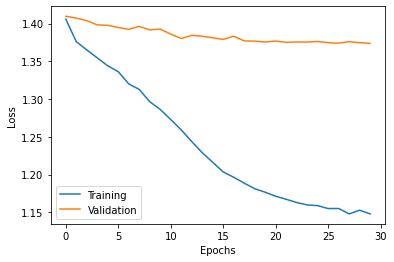

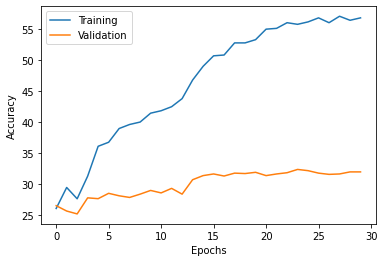

In [968]:
plt.figure()
plt.plot(np.arange(num_epochs), stats['train_losses'], label='Training')
plt.plot(np.arange(num_epochs), stats['val_losses'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.arange(num_epochs), stats['train_accuracies'], label='Training')
plt.plot(np.arange(num_epochs), stats['val_accuracies'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [877]:
# Set the network in eval mode since we're not training here

model.eval()
outputs = None

 # Turn gradient computation off
with torch.no_grad():
    outputs = compute_test_outputs(model.float(),testloader,y_test)
    
# Set the network back in training mode
model.train()
    
    
test_accuracy = test(outputs, original['y_test'])

num_examples = original['y_test'].size


print(f'Accuracy of the network on the {num_examples} test examples: {test_accuracy} %')

RuntimeError: shape '[4, -1]' is invalid for input of size 50